# DataLab Cup 4 : Unlearnable Dataset
`Neural Tangent Generalization Attacks (NTGA)`

# Dataset Download
CAUTION: If you nerver download dataset from Kaggle before, plz follow the tutorial in this page: https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

## CIFAR-10

In [6]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-cifar-10

100%|███████████████████████████████████████▉| 241M/242M [00:24<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 242M/242M [00:24<00:00, 10.3MB/s]


In [8]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-cifar-10.zip'
zip_list(file_path)

## Imagenet

In [20]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-imagenet

100%|█████████████████████████████████████▉| 1.21G/1.21G [01:55<00:00, 10.3MB/s]
100%|██████████████████████████████████████| 1.21G/1.21G [01:55<00:00, 11.2MB/s]


In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-imagenet.zip'
zip_list(file_path)

# Libraries and Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

In [2]:
!nvidia-smi

Tue Jan 11 21:05:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8    14W / 250W |     19MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[1], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Hyperparameter

In [4]:
BATCH_SIZE = 1024
MODE = 'cifar10'
# MODE = 'imagenet'

if MODE == 'cifar10':
    NUM_CLASSES = 10
    IMAGE_HEIGHT = 32
    IMAGE_WIDTH = 32
if MODE == 'imagenet':
    NUM_CLASSES = 2
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    
IMAGE_CHANNEL = 3

# Dataset

In [5]:
x_train = np.load(f'./dataset/x_train_{MODE}_unlearn.npy')
y_train = np.load(f'./dataset/y_train_{MODE}.npy')
x_val = np.load(f'./dataset/x_val_{MODE}.npy')
y_val = np.load(f'./dataset/y_val_{MODE}.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

## Data augmentation

In [6]:
MAPPING_FUNC = None

def vertical_flip(tf_img):
    return tf.image.flip_left_right(tf_img)

def horizontal_flip(tf_img):
    return tf.image.flip_up_down(tf_img)

def brightness(tf_img):
    return tf.image.random_brightness(tf_img, 0.2, 2)

def central_crop(tf_img):
    return tf.image.central_crop(tf_img, 0.8)

def noise_injection(tf_img):
    noise = tf.random.normal(shape=tf.shape(tf_img), mean=0.0, stddev=1, dtype=tf.float32)
    return tf.add(tf_img, noise)


def data_generator(image, label):
    # img = tf.image.decode_image(image, channels=3)
    img = tf.cast(image, tf.float32)
    img = img
    img.set_shape([None, None, 3])
    
    if MAPPING_FUNC is not None:
        img = MAPPING_FUNC(img)

    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    label = tf.cast(label, tf.int32)    
    return img, label

def transform_dataset(image, label):
    dataset = tf.data.Dataset.from_tensor_slices((image, label))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(label))
    return dataset

In [7]:
original_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = vertical_flip
# vertical_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = horizontal_flip
# horizontal_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = brightness
# brightness_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = central_crop
# crop_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = noise_injection
# noise_dataset = transform_dataset(x_train, y_train)

train_dataset = original_dataset
# train_dataset = train_dataset.concatenate(vertical_dataset)
# train_dataset = train_dataset.concatenate(horizontal_dataset)
# train_dataset = train_dataset.concatenate(brightness_dataset)
# train_dataset = train_dataset.concatenate(crop_dataset)
# train_dataset = train_dataset.concatenate(noise_dataset)
batched_dataset = train_dataset.shuffle(len(y_train)).batch(BATCH_SIZE, drop_remainder=True)
batched_dataset = batched_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(f'Batch size: {BATCH_SIZE}, # of batch: {len(batched_dataset)}')
print(f'Total images: {len(batched_dataset)*BATCH_SIZE}')

Total images: 39936


In [8]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

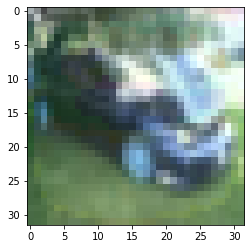

In [9]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

# Model

In [10]:
# model = Sequential([
#   keras.Input(shape=(32, 32, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(10)
# ])

# model.summary()

In [11]:
# backbone = tf.keras.applications.NASNetLarge(
#     input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL),
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     pooling=None,
#     classes=10,
# )

# x = backbone.output
# x = layers.Flatten()(x)
# x = layers.Dropout(0.5)(x)
# output_layer = layers.Dense(NUM_CLASSES)(x)
# model = tf.keras.models.Model(inputs=backbone.input, outputs=output_layer)

# model.summary()

In [12]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [13]:
input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
densenet121 = tf.keras.applications.DenseNet121(
    input_shape=input_shape,
    include_top=False,
    weights=None,
    classes=10)
densenet121.trainable = False

inputs = keras.Input(shape=input_shape)
x = densenet121(inputs, training=False)

x = conv_leaky_relu(x, 128, 3, 1)
x = conv_leaky_relu(x, 128, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         1179776   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 1, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               

# Training

In [14]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [21]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=50)

Epoch 1/50
39/39 [==============================] - 2s 54ms/step - loss: 1.5018 - acc: 0.4581 - val_loss: 1.6309 - val_acc: 0.4053
Epoch 2/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4938 - acc: 0.4615 - val_loss: 1.6445 - val_acc: 0.4045
Epoch 3/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4847 - acc: 0.4652 - val_loss: 1.6274 - val_acc: 0.4032
Epoch 4/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4862 - acc: 0.4656 - val_loss: 1.6432 - val_acc: 0.3997
Epoch 5/50
39/39 [==============================] - 2s 54ms/step - loss: 1.4934 - acc: 0.4647 - val_loss: 1.6581 - val_acc: 0.3899
Epoch 6/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4821 - acc: 0.4664 - val_loss: 1.6312 - val_acc: 0.4030
Epoch 7/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4759 - acc: 0.4697 - val_loss: 1.6368 - val_acc: 0.4119
Epoch 8/50
39/39 [==============================] - 2s 53ms/step - loss: 1.4790 - a

# Visualize

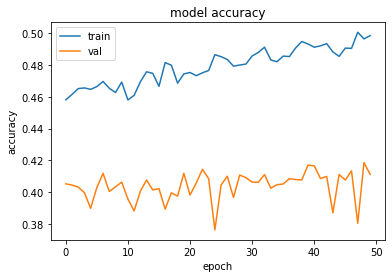

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Inference

In [23]:
x_test = np.load(f'./dataset/x_test_{MODE}.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
print(len(x_test), len(test_dataset), len(batched_test_dataset))

10000 10000 10


In [24]:
result = model.predict(x=batched_test_dataset)
final_result = np.argmax(result, axis=1)
output = pd.DataFrame({'id':range(len(final_result)), 'label':final_result})
output.to_csv(f'./submission_{MODE}.csv', header=True, index=False)